# Lecture 21 - Discriminant Functions

## Continued Discussion: $k$-Nearest Neighbors Classifier

Nearest neighbors methods compare a test point to the $k$ nearest training data points and then estimate an output value based on the desired/true output values of the $k$ nearest training points.

* Essentially, there is no "training" other than storing the training data points and their desired outputs

* In test, you need to: 
    1. Determine which $k$ neighbors in the training data are closest to the test point; and,
    2. Determine the output value for the test point.
    
In order to find the $k$ *nearest-neighbors* in the training data, you need to define a **similarity measure** or a **dissimilarity measure**. The most common dissimilarity measure is Euclidean distrance:

* Euclidean distance: $d_E(\mathbf{x}_1, \mathbf{x}_2) = \sqrt{(\mathbf{x}_1 - \mathbf{x}_2)^T(\mathbf{x}_1 - \mathbf{x}_2)}$

* City-block distance: $d_{CB}(\mathbf{x}_1,\mathbf{x}_2) = \sum_{i=1}^n |\mathbf{x}_{1i} - \mathbf{x}_{2i}|$

* Mahalanobis distance: $d_M(\mathbf{x}_1, \mathbf{x}_2) = \sqrt{(\mathbf{x}_1 - \mathbf{x}_2)^T\Sigma^{-1}(\mathbf{x}_1 - \mathbf{x}_2)}$

* Cosine angle similarity: $\cos(\theta) = \frac{\mathbf{x}_1^T \mathbf{x}_2}{\Vert\mathbf{x}_1\Vert_2^2 \Vert\mathbf{x}_2\Vert_2^2}$

* and many more.

If you are doing classification, once you find the $k$ nearest neighbors to your test point in the training data, then you can determine the class label of your test point using (most commonly) **majority vote**.

* If there are ties, they can be broken randomly or using schemes like applying the label to the closest data point in the neighborhood.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-colorblind')
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix

import seaborn as sns

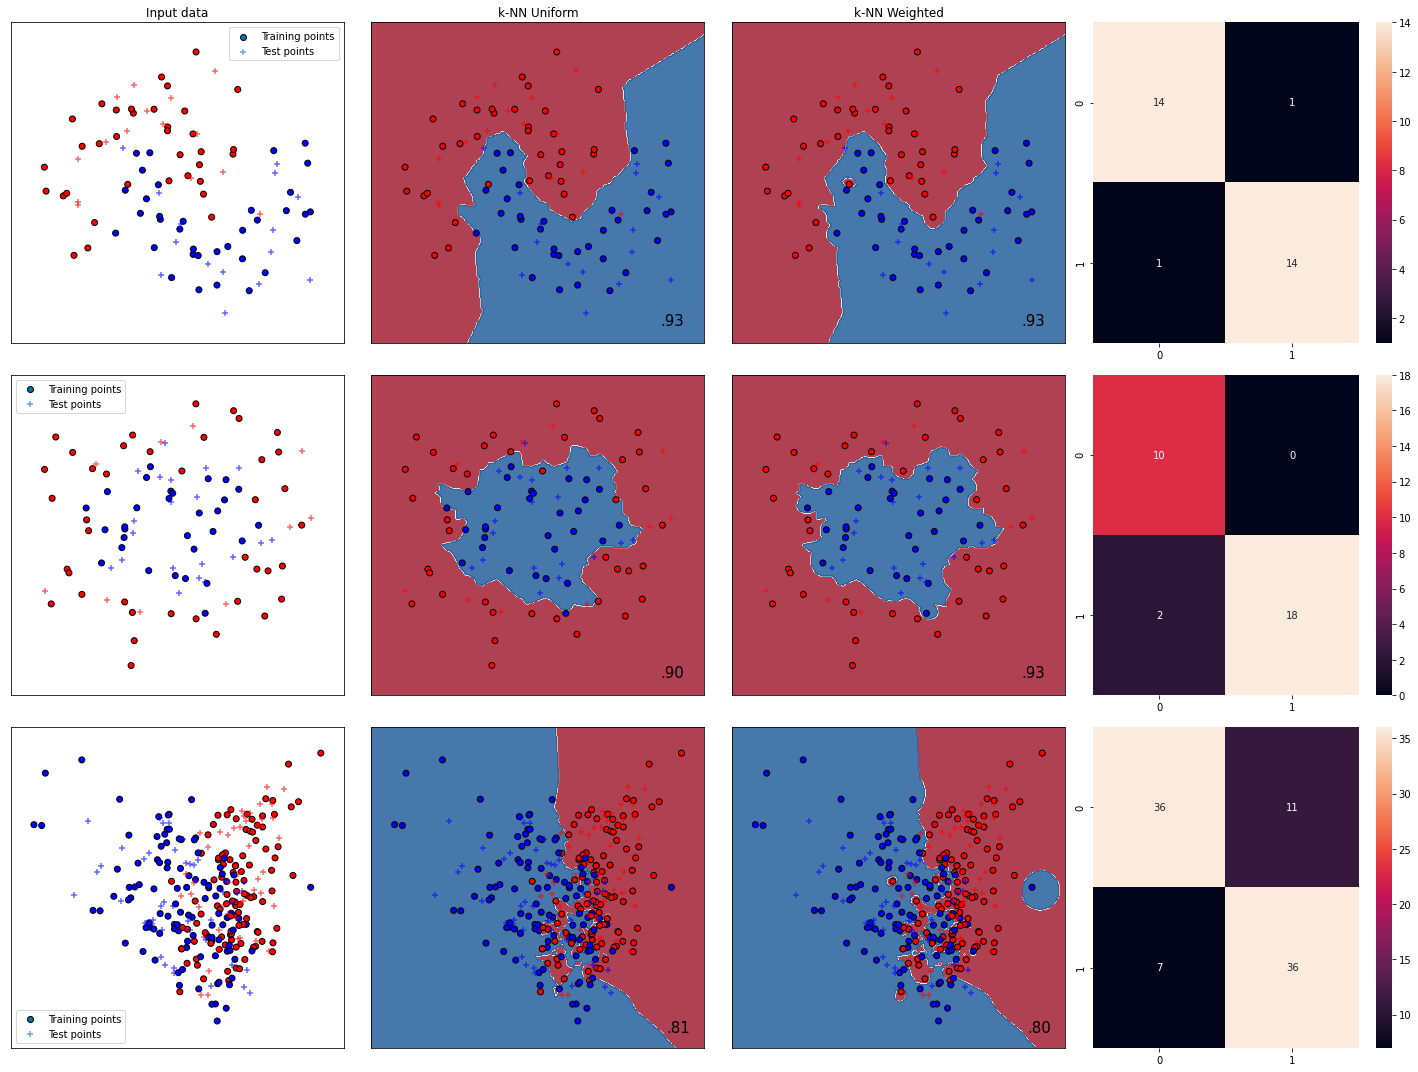

In [3]:
# Source: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py

# figure parameters
h = .02  # step size in the mesh
figure = plt.figure(figsize=(20, 15))

# set up classifiers
n_neighbors = 3
classifiers = [KNeighborsClassifier(n_neighbors, weights='uniform'), \
               KNeighborsClassifier(n_neighbors, weights='distance')]
names = ["k-NN Uniform", "k-NN Weighted"]

# Put together Data Sets
n_samples = 300
X, y = make_classification(n_samples, n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.3, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 2, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k',label='Training points')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], marker='+', c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k',label='Test points')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.legend()
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 2, i)
        clf.fit(X_train, y_train)
        y_predict = clf.predict(X_test)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
#             Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], marker='+', c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        
        i += 1
    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_predict)
    C = confusion_matrix(y_test, y_predict)
    fig = plt.subplot(len(datasets), len(classifiers) + 2, i)
    sns.heatmap(C,annot=True)
    
    
#     fig.plot(fpr,tpr)
#     plt.xlabel('FPR')
#     plt.ylabel('TPR')
#     plt.title(auc(fpr, tpr))
    i += 1
        
    

plt.tight_layout()
plt.show()

# Linear Discriminant Functions

So far we designed classifiers based on probability density or probability functions. In some cases, we saw that the resulting classifiers were equivalent to a set of linear discriminant functions. 

We will now focus on the design of linear classifiers, irrespective of the underlying distributions describing the training data. 
* The major advantage of linear classifiers is their simplicity and computational attractiveness.

* We will develop techniques for the computation of the corresponding linear functions. In the sequel we will focus on a more general problem, in which a linear classifier cannot classify correctly all feature vectors, yet we will seek ways to design an optimal linear classifier by adopting an appropriate optimality criterion.

Linear discriminant functions are typically presented for a 2-class problem due to its geometry interpretation.
* Linear discriminant functions are generalized to $K>2$ classes

We will learn 3 methods to optimize the parameters of a linear discriminant function (classifier):

1. Least Squares Classification
2. Fisher's Linear Discriminant
3. The Perceptron Algorithm

## Linear Decision Boundary

Suppose we have a 2-class problem and we want to find a *linear boundary* that separates the two classes, such that, above the decision boundary all points belong to one class and below the decision boundary all points belong to the other class.

* To do this, we would want the mean of the two classes to be as far a part as possible, and the variance of each class to be as small as possible.

We can design a cost function as the ratio between the squared difference of the means over the sum of the variances. In order to find a linear decision boundary, we want to maximize this cost function.

$$\frac{(m_2 - m_1)^2}{s_1^2 + s_2^2}$$

This cost function is a function of the parameters $\mathbf{w}$ that characterize the line or hyperplane.

* The line of hyperplane perpendicular to the decision boundary will point in the **direction of projection** that preserves class separability.

* We will end up with far and compact clusters which are easy to linearly separate.

We will begin with linear discriminant functions:
$$y(\mathbf{\overrightarrow{x}}) = \mathbf{\overrightarrow{w}}^T\mathbf{x} + w_0$$

*Looks pretty familiar, right?* If you are on one side of the line, then you are in class 1.  If you are on the other side of the line, then you are in class 2.  So, the decision boundary is $y(\mathbf{\overrightarrow{x}}) = 0$

* The distance of a point to the decision boundary is: $\frac{y(\mathbf{\overrightarrow{x}})}{\left\| \mathbf{\overrightarrow{w}} \right\|}$ 
    * See Figure 4.1 from textbook:

In [ ]:
from IPython.display import Image
Image('figures/Figure4.1.png', width=800)

We could use a **least squares** error function to solve for $\mathbf{\overrightarrow{w}}$ and $w_0$ as we did in regression.  But, there are some issues. *Can you think of any?*

* In regression, the prediction label will be a continuous number between $[-1,1]$. So the predicted class label will be for example: -0.8, 0.4 or 0.01. To simplify, we can say, if the predicted class $y \geq 0$ than is class 1 otherwise is class 0.
* The problem that comes about is that, if we look at the distribution of our errors, in our estimation $\epsilon = t-y$ is not Gaussian.    
* The errors samples are assumed independent, with a mean and a variance independent from each other.
* If we use regression, what we going end up with is an error distribution where the variance is dependent on the mean. This becomes a signal-dependent problem therefore regression is not a good approach to classification.

## Fisher's Linear Discriminant

A very popular type of a linear discriminant is the **Fisher's Linear Discriminant**.

* Given two classes, we can compute the mean of each class:
$$\mathbf{\overrightarrow{m}}_1 = \frac{1}{{N}_1}\sum_{n\in C_1} \mathbf{\overrightarrow{x}_n}$$

$$\mathbf{\overrightarrow{m}_2} = \frac{1}{N_2}\sum_{n\in C_2} \mathbf{\overrightarrow{x}_n}$$

We can maximize the separation of the means:

$$m_2 - m_1 = \mathbf{\overrightarrow{w}}^T(\mathbf{\overrightarrow{m}}_2 - \mathbf{\overrightarrow{m}}_1)$$

* $\mathbf{\overrightarrow{w}}^T\mathbf{\overrightarrow{x}}$ takes a $D$ dimensional data point and projects it down to 1-D with a weight sum of the original features. We want to find a weighting that maximizes the separation of the class means. 

* Not only do we want well separated means for each class, but we also want each class to be *compact* to minimize overlap between the classes. 

* Consider the *within class variance:*

\begin{align}
s_k^2 = \sum_{n \in C_k} (y_n - m_k)^2 &= \sum_{n \in C_k} (\mathbf{\overrightarrow{w}}^T\mathbf{\overrightarrow{x}}_n - m_k)^2 \\
&= \mathbf{\overrightarrow{w}}^T \sum_{n \in C_k} (\mathbf{\overrightarrow{x}}_n - \mathbf{\overrightarrow{m}_k}) (\mathbf{\overrightarrow{x}}_n - \mathbf{\overrightarrow{m}_k})^T \mathbf{\overrightarrow{w}}
\end{align}

* So, we want to minimize within class variance and maximize between class separability. How about the following objective function:

\begin{eqnarray}
J(\mathbf{w}) &=& \frac{(m_2 - m_1)^2}{s_1^2 + s_2^2}\\
      &=& \frac{\mathbf{\overrightarrow{w}}^T(\mathbf{\overrightarrow{m}}_2 - \mathbf{\overrightarrow{m}}_1)(\mathbf{\overrightarrow{m}}_2 - \mathbf{\overrightarrow{m}}_1)^T\mathbf{\overrightarrow{w}}}{\sum_{n \in C_1} (\mathbf{\overrightarrow{w}}^T\mathbf{\overrightarrow{x}}_n - m_1)^2 + \sum_{n \in C_2} (\mathbf{\overrightarrow{w}}^T\mathbf{\overrightarrow{x}}_n - m_2)^2}\\
	  &=& \frac{\mathbf{\overrightarrow{w}}^T(\mathbf{\overrightarrow{m}}_2 - \mathbf{\overrightarrow{m}}_1)(\mathbf{\overrightarrow{m}}_2 - \mathbf{\overrightarrow{m}}_1)^T\mathbf{\overrightarrow{w}}}{\mathbf{\overrightarrow{w}}^T\left(\sum_{n \in C_1} (\mathbf{\overrightarrow{x}}_n - \mathbf{\overrightarrow{m}}_1)(\mathbf{\overrightarrow{x}}_n - \mathbf{\overrightarrow{m}}_1)^T + \sum_{n \in C_2} (\mathbf{\overrightarrow{x}}_n - \mathbf{\overrightarrow{m}}_2)(\mathbf{\overrightarrow{x}}_n - \mathbf{\overrightarrow{m}}_2)^T\right)\mathbf{\overrightarrow{w}}}\\
	  &=& \frac{\mathbf{\overrightarrow{w}}^T\mathbf{S}_B\mathbf{\overrightarrow{w}}}{\mathbf{\overrightarrow{w}}^T\mathbf{S}_W\mathbf{\overrightarrow{w}}}
\end{eqnarray}

where

$$S_B = (\mathbf{\overrightarrow{m}}_2 - \mathbf{\overrightarrow{m}}_1)(\mathbf{\overrightarrow{m}}_2 - \mathbf{\overrightarrow{m}}_1)^T$$

and 

$$S_W= \sum_{n \in C_1} (\mathbf{\overrightarrow{x}}_n - \mathbf{\overrightarrow{m}}_1)(\mathbf{\overrightarrow{x}}_n - \mathbf{\overrightarrow{m}}_1)^T + \sum_{n \in C_2} (\mathbf{\overrightarrow{x}}_n - \mathbf{\overrightarrow{m}}_2)(\mathbf{\overrightarrow{x}}_n - \mathbf{\overrightarrow{m}}_2)^T$$

* Ok, so let's optimize:

\begin{eqnarray}
\frac{\partial J(\mathbf{\overrightarrow{w}})}{\partial \mathbf{\overrightarrow{w}}} &=& \frac{2(\mathbf{\overrightarrow{w}}^T\mathbf{S}_W\mathbf{\overrightarrow{w}})\mathbf{S}_B\mathbf{\overrightarrow{w}} - 2(\mathbf{\overrightarrow{w}}^T\mathbf{S}_B\mathbf{\overrightarrow{w}})\mathbf{S}_W\mathbf{\overrightarrow{w}}}{(\mathbf{\overrightarrow{w}}^T\mathbf{S}_W\mathbf{\overrightarrow{w}})^2} = 0 \\
0 &=& \ \frac{\mathbf{S}_B\mathbf{\overrightarrow{w}}}{(\mathbf{\overrightarrow{w}}^T\mathbf{S}_W\mathbf{\overrightarrow{w}})} -\frac{(\mathbf{\overrightarrow{w}}^T\mathbf{S}_B\mathbf{\overrightarrow{w}})\mathbf{S}_W\mathbf{\overrightarrow{w}}}{(\mathbf{\overrightarrow{w}}^T\mathbf{S}_W\mathbf{\overrightarrow{w}})^2} \\
 (\mathbf{\overrightarrow{w}}^T\mathbf{S}_W\mathbf{\overrightarrow{w}})\mathbf{S}_B\mathbf{\overrightarrow{w}} &=& (\mathbf{\overrightarrow{w}}^T\mathbf{S}_B\mathbf{\overrightarrow{w}})\mathbf{S}_W\mathbf{\overrightarrow{w}} \\
 \mathbf{S}_B \mathbf{\overrightarrow{w}} &=& \frac{\mathbf{\overrightarrow{w}}^T\mathbf{S}_B\mathbf{\overrightarrow{w}}}{\mathbf{\overrightarrow{w}}^T\mathbf{S}_W\mathbf{\overrightarrow{w}}} \mathbf{S}_W\mathbf{\overrightarrow{w}}\\
 \mathbf{S}_W^{-1}\mathbf{S}_B\mathbf{\overrightarrow{w}} &=& \lambda\mathbf{\overrightarrow{w}}
\end{eqnarray}

where the scalar $\lambda = \frac{\mathbf{\overrightarrow{w}}^T\mathbf{S}_B\mathbf{\overrightarrow{w}}} { \mathbf{\overrightarrow{w}}^T\mathbf{S}_W\mathbf{\overrightarrow{w}}}$

* **Does this look familiar?**

This is the generalized eigenvalue problem!

* So the direction of projection correspond to the eigenvectors of $\mathbf{S}_W^{-1}\mathbf{S}_B$ with the largest eigenvalues.

The solution is easy when $S_w^{-1} = (\Sigma_1 + \Sigma_2)^{-1}$ exists.

In this case, if we use the definition of $S_B = (\mathbf{\overrightarrow{m}}_2 - \mathbf{\overrightarrow{m}}_1)(\mathbf{\overrightarrow{m}}_2 - \mathbf{\overrightarrow{m}}_1)^T$:

\begin{align}
S_W^{-1}S_B\mathbf{\overrightarrow{w}} &= \lambda\mathbf{\overrightarrow{w}}\\
S_W^{-1}(\mathbf{\overrightarrow{m}}_2-\mathbf{\overrightarrow{m}}_1)(\mathbf{\overrightarrow{m}}_2-\mathbf{\overrightarrow{m}}_1)^T\mathbf{\overrightarrow{w}} &= \lambda\mathbf{\overrightarrow{w}}
\end{align}

Noting that $\alpha = (\mathbf{\overrightarrow{m}}_2-\mathbf{\overrightarrow{m}}_1)^T\mathbf{\overrightarrow{w}}$ is a constant, this can be written as:

$$S_W^{-1}(\mathbf{\overrightarrow{m}}_2-\mathbf{\overrightarrow{m}}_1) = \frac{\lambda}{\alpha}\mathbf{\overrightarrow{w}}$$

* Since we don't care about the magnitude of $\mathbf{\overrightarrow{w}}$:

$$\mathbf{\overrightarrow{w}}^* = S_W^{-1}(\mathbf{\overrightarrow{m}}_2-\mathbf{\overrightarrow{m}}_1) = (\Sigma_1 + \Sigma_2)^{-1}(\mathbf{\overrightarrow{m}}_2-\mathbf{\overrightarrow{m}}_1)$$

Make sure $\mathbf{\overrightarrow{w}}^*$ is a unit vector by taking: $\mathbf{\overrightarrow{w}}^* \leftarrow \frac{\mathbf{\overrightarrow{w}}^*}{\Vert\mathbf{\overrightarrow{w}}^*\Vert}$

* Note that if the within-class covariance, $S_W$, is isotropic, so that $S_W$ is proportional to the unit matrix, we find that $\mathbf{\overrightarrow{w}}$ is proportional to the difference of the class means.

* This result is known as *Fisher's linear discriminant*, although strictly it is not a discriminant but rather a specific choice of direction for projection of the data down to one dimension. However, the projected data can subsequently be used to construct a discriminant, by choosing a threshold $y_0$ so that we classify a new point as belonging to $C_1$ if $y(x) \geq y_0$ and classify it as belonging to $C_2$ otherwise.

Also, note that:
* For a classification problem with Gaussian classes of equal covariance $\Sigma_i=\Sigma$, the boundary is the plane of normal:
$$\mathbf{\overrightarrow{w}} = \Sigma^{-1}(\mathbf{\overrightarrow{m}}_i-\mathbf{\overrightarrow{m}}_j)$$

* If $\Sigma_2=\Sigma_1$, this is also the LDA solution.

This gives two different **interpretations** of LDA:

* It is optimal *if and only if* the classes are Gaussian and have equal covariance.

* A classifier on the LDA features, is equivalent to the boundary after the approximation of the data by two Gaussians with equal covariance.

The final discriminant decision boundary is $\mathbf{\overrightarrow{y}} = \mathbf{\overrightarrow{w}}^*\mathbf{\overrightarrow{x}} + w_0$

The *bias* term $w_0$ can be defined as:

$$w_0 = \left(\frac{1}{N_1}\sum_{n\in C_1}\overrightarrow{x}_n + \frac{1}{N_2}\sum_{n\in C_2}\overrightarrow{x}_n \right)\mathbf{\overrightarrow{w}}^*$$

* An extension to multi-class problems has a similar derivation.

**Limitations** of LDA:

1. LDA produces at most $C-1$ feature projections, where $C$ is the number of classes.

2. If the classification error estimates establish that more features are needed, some other method must be employed to provide those additional features.

3. LDA is a parametric method (it assumes unimodal Gaussian likelihoods).

4. If the distributions are significantly non-Gaussian, the LDA projections may not preserve complex structure in the data needed for classification.

5. LDA will also fail if discriminatory information is not in the mean but in the variance of the data.

A popular variant of LDA are the **Multi-Layer Perceptrons** (or MLPs).

In [ ]:
def fisherDiscriminant(data,t):
    data1 = data[t==0,:]
    data2 = data[t==1,:]
    mean1 = np.atleast_2d(np.mean(data1,0))
    mean2 = np.atleast_2d(np.mean(data2,0))
    Sw1 = np.dstack([(data1[i,:]-mean1).T@(data1[i,:]-mean1) for i in range(data1.shape[0])])
    Sw2 = np.dstack([(data2[i,:]-mean2).T@(data2[i,:]-mean2) for i in range(data2.shape[0])])
    Sw = np.sum(Sw1,2) + np.sum(Sw2,2)
    w = np.linalg.inv(Sw)@(mean2 - mean1).T
    w = w/np.linalg.norm(w)
    data_t = data@w
    return w, data_t

In [ ]:
def discriminant(data, labels, v):
    v_perp = np.array([v[1], -v[0]])
    b = ((np.mean(data[labels==0,:],axis=0)+np.mean(data[labels==1,:],axis=0))/2)@v
    lambda_vec = np.linspace(-2,2,len(data))
    decision_boundary = b * v + lambda_vec * v_perp
    return decision_boundary

In [ ]:
# Generate Data

N1 = 100 #number of points for class1
N2 = 100 #number of points for class0
covM = [1,0.01]*np.eye(2) # covariance matrix
data = np.random.multivariate_normal([0,0], covM, N1) #generate points  for class 1
X = np.vstack((data, np.random.multivariate_normal([1,1], covM, N2))) #generate points for class 0
labels = np.hstack((np.ones(N1),np.zeros(N2)))

plt.scatter(X[:,0],X[:,1],c=labels); plt.show();

In [ ]:
v, Y = fisherDiscriminant(X,labels)

fig = plt.figure()
plt.scatter(X[:,0],X[:,1],c=labels)

decision_boundary = discriminant(X, labels, v);
plt.plot(decision_boundary[0,:], decision_boundary[1,:],'b',linewidth=2, label='Decision Boundary')
plt.title("LDA"); plt.axis('equal'); plt.legend(loc='best'); plt.show()